# parameter sandbox

## From Chris Chapmans "DIVAnd Create 2d Slice" - Create_BG_Temperature_Field_Synthetic.ipynb

### notes from DIVAnd Create 2d Slice by CChapman
This notebook illustrates how to use DIVAnd to create a simple map of temperature over the CARSv2 region for use as a background field.
NOTE: This is my first attempt, and optimisation hasn't been undertaken - CChapman


In [1]:
using DIVAnd
using PyPlot
using NCDatasets
using DataStructures
using Dates
using Statistics
using Polynomials
using DataFrames

### Load the data from the netcdf files. Individual observation "platforms" are found in different netcdf files, following WOD convention.

In [2]:
# data_path  = "/tube1/cha674/CARS_2022_ancillary_data/Synthetic_WOD/2018/"
data_path  = "../src/data/cha674_CARS_2022_ancillary_data/Synthetic_WOD/2018/"
data_file_stem = "synthetic_wod_2018_"

#platform_types = ["ctd","pfl","xbt","mrb","gld","osd"]
platform_types = ["pfl"]

WOD_datasets = []

for i_platform in platform_types
    WOD_data_full_path = string(data_path,data_file_stem,i_platform,".nc")
    println(WOD_data_full_path)
    ds = Dataset(WOD_data_full_path)
    push!(WOD_datasets,ds)
end

../src/data/cha674_CARS_2022_ancillary_data/Synthetic_WOD/2018/synthetic_wod_2018_pfl.nc


## Convert the raw times (in nanosecconds since) to date time format

In [3]:
start_date = WOD_datasets[1]["time"].attrib["units"][19:end]
start_date  = DateTime(start_date[1:19],dateformat"y-m-d HH:MM:SS")

time_dates = start_date + Dates.Second.(Int64.(floor.(WOD_datasets[1]["time"].var[:]*1.0e-9) ))

┌ Warning: unknown units nanoseconds
└ @ NCDatasets ~/.julia/packages/NCDatasets/xVEGJ/src/cfvariable.jl:407
┌ Warning: unknown units nanoseconds
└ @ NCDatasets ~/.julia/packages/NCDatasets/xVEGJ/src/cfvariable.jl:407


17324-element Vector{DateTime}:
 2018-01-01T00:59:02
 2018-01-01T00:02:48
 2018-01-01T01:15:56
 2018-01-01T01:18:45
 2018-01-01T01:32:48
 2018-01-01T02:26:15
 2018-01-01T02:57:10
 2018-01-01T03:50:37
 2018-01-01T03:28:07
 2018-01-01T03:36:31
 2018-01-01T03:42:10
 2018-01-01T04:27:10
 2018-01-01T04:07:29
 ⋮
 2018-12-31T18:56:15
 2018-12-31T18:30:56
 2018-12-31T19:46:51
 2018-12-31T20:20:37
 2018-12-31T20:59:59
 2018-12-31T21:36:31
 2018-12-31T21:39:21
 2018-12-31T22:07:29
 2018-12-31T22:01:51
 2018-12-31T22:10:18
 2018-12-31T22:04:40
 2018-12-31T23:26:15

## Format and concatenate the data from the netcdf files in a form that DIVAnd can understand.
We also remove NaN values and data that is identically equal to zero. Here is where checking the QC-flags could come in handy.

In [4]:
longitude = []
latitude  = []
temperature = []
time =  []
depth       = []
for (platform_index, current_platform) in enumerate(platform_types)
    println(platform_index,current_platform)
    longitude   =  vcat(longitude,WOD_datasets[platform_index]["longitude"].var[:,:])
    latitude   =  vcat(latitude,WOD_datasets[platform_index]["latitude"].var[:,:])
    temperature = vcat(temperature,WOD_datasets[platform_index]["temp"].var[1,:])
    time        = vcat(time,WOD_datasets[platform_index]["time"].var[:,:])
    depth       =  vcat(depth,WOD_datasets[platform_index]["depth"].var[1])

    
end
deleteat!(longitude  , findall(isnan.(temperature)) )
deleteat!(latitude   , findall(isnan.(temperature)) )
deleteat!(time       , findall(isnan.(temperature)) )
deleteat!(temperature, findall(isnan.(temperature)) )

deleteat!(longitude  , findall(temperature.==0) )
deleteat!(latitude   , findall(temperature.==0) )
deleteat!(time       , findall(temperature.==0) )
deleteat!(temperature, findall(temperature.==0) )

observation_id =[0:length(longitude):1]

1pfl


┌ Warning: unknown units nanoseconds
└ @ NCDatasets ~/.julia/packages/NCDatasets/xVEGJ/src/cfvariable.jl:407


1-element Vector{StepRange{Int64, Int64}}:
 0:17271:0

### Check-obs - inbuilt function to get range of observations in both geographic space and data space. Good for identifying any remaining outliers.

In [5]:
checkobs((longitude.+360.0,latitude,depth,time),temperature,observation_id)

              minimum and maximum of obs. dimension 1: (90.0059814453125, 179.94830322265625)
              minimum and maximum of obs. dimension 2: (

[ Info: Checking ranges for dimensions and observations


-49.95988f0, -0.052f0)
              minimum and maximum of obs. dimension 3: (0.5412807464599609, 0.5412807464599609)
              minimum and maximum of obs. dimension 4: (-3373920283648, 31530433681690624)
                          minimum and maximum of data: (2.502504587173462, 31.455183029174805)


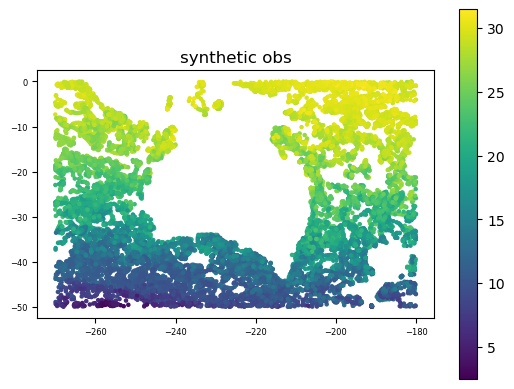

PyObject Text(0.5, 1.0, 'synthetic obs')

In [6]:
figure("Synth-WOD")
ax = subplot(1,1,1)
scatter(longitude, latitude, c=temperature,s=5)
aspectratio = 1/cos(mean(latitude) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)
colorbar()
title("synthetic obs")
#colorbar(orientation="vertical")

# Note that there is an obvious dependence of the temperature with latitude. 
## We remove this dependence using a linear fit to a quadratic function. Failure to remove this latitudinal dependence results in a background field that simply reflects the north-south temperature gradient.

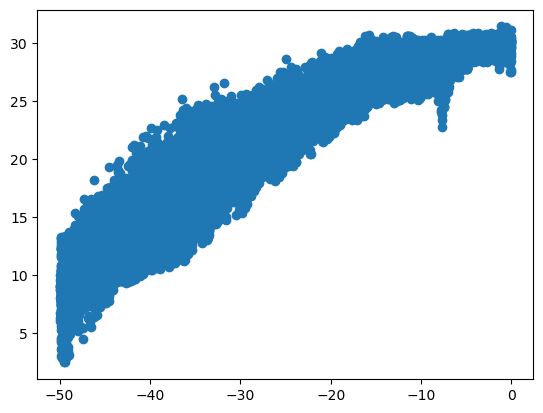

PyObject <matplotlib.collections.PathCollection object at 0x2a2235660>

In [7]:
scatter(latitude,temperature)

## Linear-fit to latitude achieved using the "curve_fit" package. 

In [8]:
using LsqFit
@. model(x, p) = p[1] + p[2]*x + p[3]*x*x
p0 = [0.5,0.5,0.5]
fit_temperature_to_latitude = curve_fit(model, latitude, temperature, p0)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Any}}([30.359170964855615, 0.13031780576106622, -0.006502229245739921], [-2.2762983434856743, 0.7112141088966943, 0.8550536901365113, -0.4959401129731198, -3.687777595192692, -5.680038046772012, -0.33806407081881673, 0.4527434095040306, 0.5778962625525637, 0.5562625991700578  …  1.3338292215435388, -0.9410683879958306, 1.5097894815717758, -0.8586934518651752, -0.6745469654292524, -2.6214128399538836, 0.3920029146666515, 3.4541345633460807, 0.872703605129157, -1.619401097806879], [1.00000000000367 -17.81500053412858 317.37424402862825; 1.00000000000367 -15.880040168617436 252.17567576135062; … ; 1.00000000000367 -45.01800155626476 2026.6204641317497; 1.00000000000367 -15.963100433326826 254.8205754453273], true, Any[])

In [9]:
fit_temperature_to_latitude.param

3-element Vector{Float64}:
 30.359170964855615
  0.13031780576106622
 -0.006502229245739921

Plot the residuals after the the quadratic fitting exercise to check if the latitudinal temperature gradient has been removed.

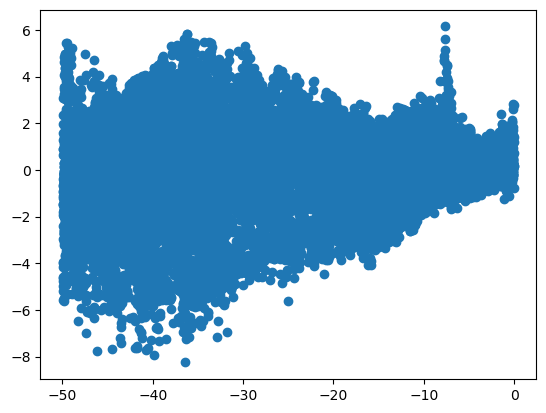

PyObject <matplotlib.collections.PathCollection object at 0x2a2092260>

In [10]:
scatter(latitude,fit_temperature_to_latitude.resid)

In [11]:
temperature_residual = fit_temperature_to_latitude.resid

17271-element Vector{Float64}:
 -2.2762983434856743
  0.7112141088966943
  0.8550536901365113
 -0.4959401129731198
 -3.687777595192692
 -5.680038046772012
 -0.33806407081881673
  0.4527434095040306
  0.5778962625525637
  0.5562625991700578
 -0.21726771267706368
  2.687832656745842
 -1.3331185590654009
  ⋮
  0.1906753874940854
 -1.3655141392359305
  1.3338292215435388
 -0.9410683879958306
  1.5097894815717758
 -0.8586934518651752
 -0.6745469654292524
 -2.6214128399538836
  0.3920029146666515
  3.4541345633460807
  0.872703605129157
 -1.619401097806879

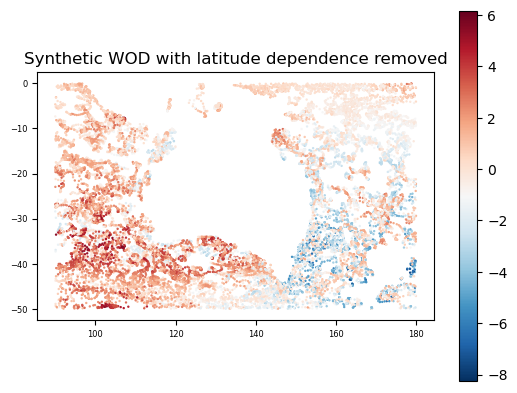

PyObject <matplotlib.colorbar.Colorbar object at 0x2a2253b20>

In [12]:
figure("Synth-WOD")
ax = subplot(1,1,1)
scatter(longitude.+360, latitude, c=temperature_residual,cmap="RdBu_r",s=0.5)
aspectratio = 1/cos(mean(latitude) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)
title("Synthetic WOD with latitude dependence removed")
colorbar()

## Load the bathymetry for creation of the land-sea mask

In [13]:
bathname = "../src/data/TMoore-test-input/gebco_30sec_16.nc"
bathisglobal = true

dx = 0.5 # longitude resolution in degrees
dy = 0.5 # latitude resolution in degrees

lonr = 90.:dx:180.; # the range of longitudes (start:step:end)
latr = -50.:dy:0.; # the range of latitudes (start:step:end)

bx,by,b = extract_bath(bathname,true,lonr,latr)

(89.39999999998471:0.13333333333332575:180.59999999997953, -50.59999999999805:0.13333333333333997:0.6000000000044992, [4059.3125 4077.8203125 … 3669.8203125 3215.8515625; 3981.33984375 4181.8515625 … 3460.91796875 2797.3125; … ; 4661.52734375 4491.2421875 … 5470.984375 5483.15234375; 4570.25390625 4523.3515625 … 5517.64453125 5459.37890625])

# plot bathymetry with obs

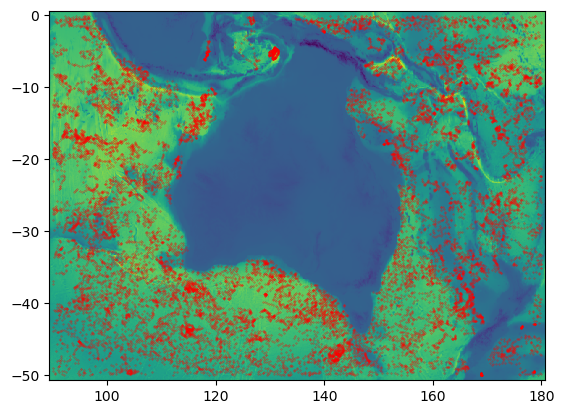

PyObject <matplotlib.collections.PathCollection object at 0x2b15363e0>

In [18]:
pcolormesh(bx,by,b')
scatter(longitude.+360,latitude,s=0.05,c="red")

# Create the grid and grid-metric (ie. the effective distances in meters)

In [19]:
xi,yi,mask = load_mask(bathname,true,lonr,latr,0)
pm,pn = DIVAnd_metric(lonr,latr);
xi,yi = ndgrid(xi,yi)

([90.0 90.0 … 90.0 90.0; 90.5 90.5 … 90.5 90.5; … ; 179.5 179.5 … 179.5 179.5; 180.0 180.0 … 180.0 180.0], [-50.0 -49.5 … -0.5 0.0; -50.0 -49.5 … -0.5 0.0; … ; -50.0 -49.5 … -0.5 0.0; -50.0 -49.5 … -0.5 0.0])

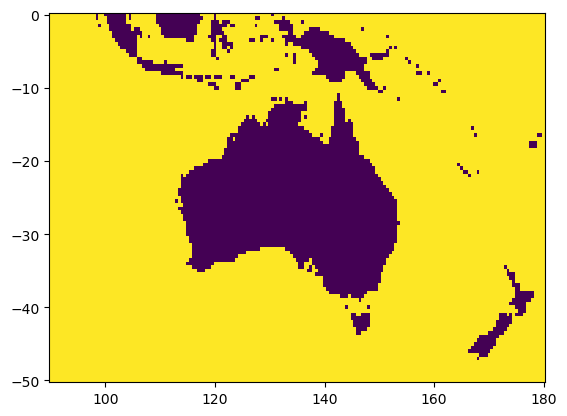

PyObject <matplotlib.collections.QuadMesh object at 0x2b1586d10>

In [20]:
pcolormesh(xi,yi,mask)

## the removed lat dependence

In [23]:
lat_dependence = model(yi,fit_temperature_to_latitude.param)

181×101 Matrix{Float64}:
 7.58771  7.97635  8.36175  8.74389  …  30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389  …  30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389  …  30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592


# Run DIVAndrun
#### Correlation length scales are chosen following Chris Roach's Oxygen Atlas and have not been optimised

In [22]:
lenx = 500.0 * 1000.0
leny = 250.0 * 1000.0
lent = 5.0
epsilon = 1.0
#wu= 1.0
#temperature_anom = temperature .- mean(temperature)

fi, s = DIVAndrun(mask,(pm,pn),(xi,yi),(longitude.+360,latitude),temperature_residual,(lenx,leny),epsilon) #, moddim=md)

([0.6198240502489596 0.5654659647346042 … 0.3434055249452351 0.36763017036606693; 0.8831456279808558 0.8572468936194068 … 0.42091090715165297 0.4721097147121077; … ; -1.0748166854139232 -0.8676193300851338 … 1.2692810290723158 1.4268269068660981; -0.9855295661744119 -0.8640849129264637 … 1.1394401912849377 1.327128747200801], DIVAnd.DIVAnd_struct{Float64, Int64, 2, SparseArrays.SparseMatrixCSC{Float64, Int64}}(2, 2, 1.5707963330122983e12, statevector{1, 2}((Bool[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1],), 1, [14714], [18281], [(181, 101)], [0, 14714], 14714, [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  18272, 18273, 18274, 18275, 18276, 18277, 18278, 18279, 18280, 18281]], [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  14705, 14706, 14707, 14708, 14709, 14710, 14711, 14712, 14713, 14714]]), sparse([1, 2, 182, 1, 2, 3, 183, 2, 3, 4  …  14711, 14712, 14713, 14560, 14712, 14713, 14714, 14561, 14713, 14714], [1, 1, 1, 2, 2, 2, 2, 3, 3, 3  …  14712, 14712, 14712, 14713, 14713, 14713, 14713, 14714, 14714

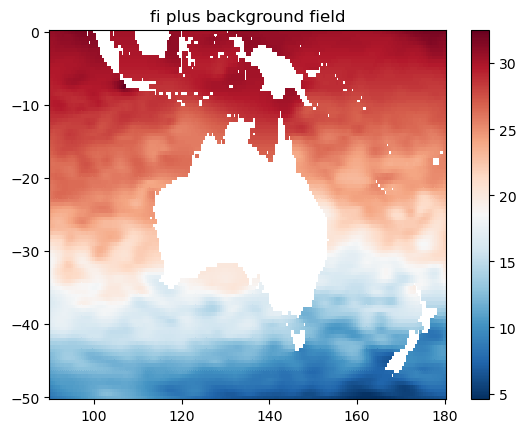

PyObject Text(0.5, 1.0, 'fi plus background field')

In [24]:
pcolor(xi, yi, fi.+lat_dependence,cmap="RdBu_r")
colorbar()
title("fi plus background field")

# ------------------------

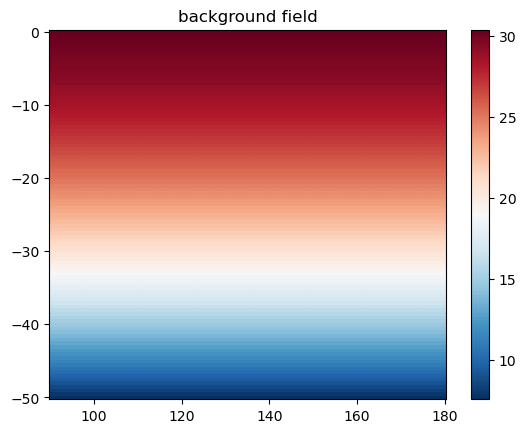

PyObject Text(0.5, 1.0, 'background field')

In [27]:
pcolor(xi, yi, lat_dependence,cmap="RdBu_r"); 
colorbar()
title("background field")

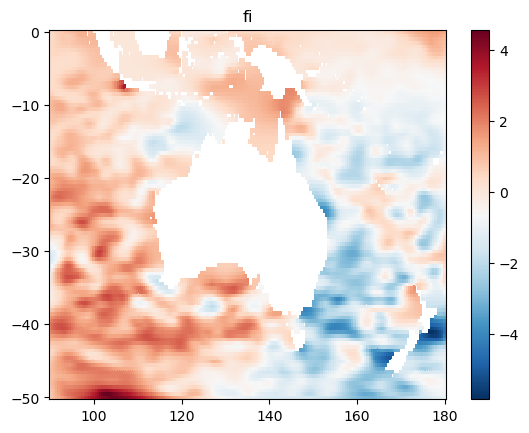

PyObject Text(0.5, 1.0, 'fi')

In [28]:
pcolor(xi, yi, fi,cmap="RdBu_r"); 
colorbar()
title("fi")

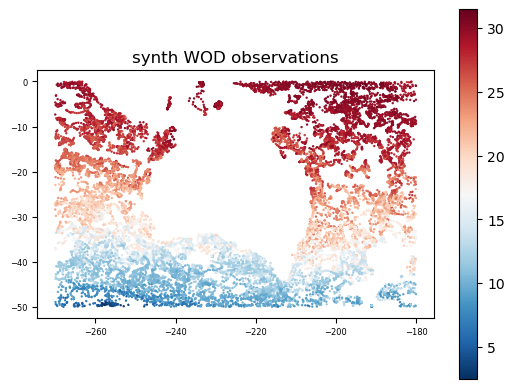

PyObject Text(0.5, 1.0, 'synth WOD observations')

In [30]:
ax = subplot(1,1,1)
scatter(longitude, latitude, c=temperature,s=0.5,cmap="RdBu_r")
aspectratio = 1/cos(mean(latitude) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)
colorbar()
title("synth WOD observations")

# Error

see: DIVAnd docs

In [31]:
dataresiduals = DIVAnd_residualobs(s,fi)

17271-element Vector{Float64}:
 -0.3055614844864558
 -0.27298760246965936
  0.7025465928550879
  0.034255306599659696
 -0.6705035884171995
 -3.3456599345310036
  0.0720429317857636
 -1.1229652212542474
 -0.15963758447552923
 -0.028003915675193225
 -0.09700028228340703
  0.130514765275354
 -1.8672493700177042
  ⋮
 -0.5913913931892412
 -1.3918411428941984
 -0.277084136666061
 -0.31210900097271765
  1.1384477754610545
 -0.04108071453438
 -0.16131408328282015
 -2.288326582076497
 -1.394792592374291
  1.0324575614978095
 -0.0609472545558839
 -0.08993439159806127

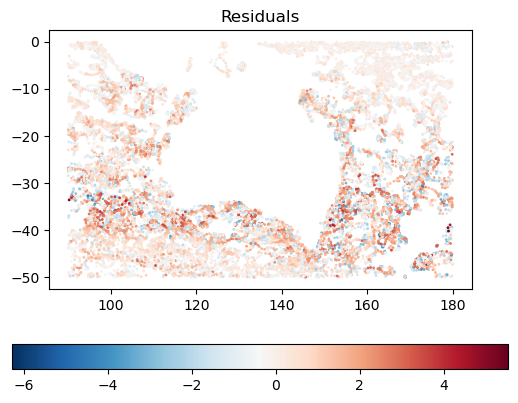

PyObject Text(0.5, 1.0, 'Residuals')

In [32]:
figure()
scatter(longitude.+360, latitude,s=1,c=dataresiduals,cmap=ColorMap("RdBu_r"));
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))
title("Residuals")

In [33]:
mean_error = mean(abs.(dataresiduals))

1.032016145033229

### DIVAnd_residualobs(s,fi) always yields "better" result for lower epsilon - even rediculously overfitted?
How does this compare to the approach in DIVAnd workshops?

# build some basic julia code here to loop over different lenx vs leny

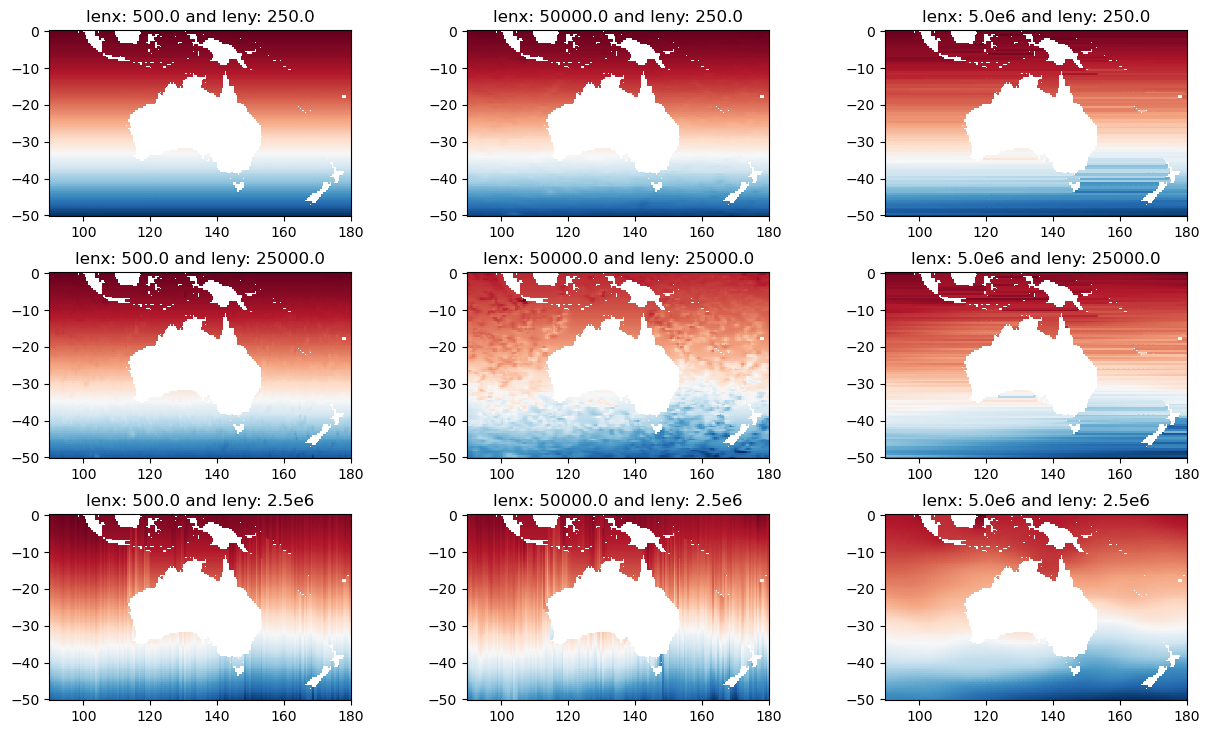

In [34]:
subplots_adjust(left = 0.1, bottom = 0.1, right = 2, top = 2, wspace = 0.1, hspace = 0.3)
for i=1:3
    for j=1:3
        lenx=500*100.0^(i-1)
        leny=250*100.0^(j-1)
        epsilon2=1.0
        #@show i,j,len*sqrt(epsilon2),len,epsilon2
        fi, s = DIVAndrun(mask,(pm,pn),(xi,yi),(longitude.+360,latitude),temperature_residual,(lenx,leny),epsilon2);
        subplot(4,3,3*j+i)
        pcolor(xi,yi,fi.+model(yi,fit_temperature_to_latitude.param),cmap="RdBu_r");
        gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))
        title("lenx: $lenx and leny: $leny") 
    end
end

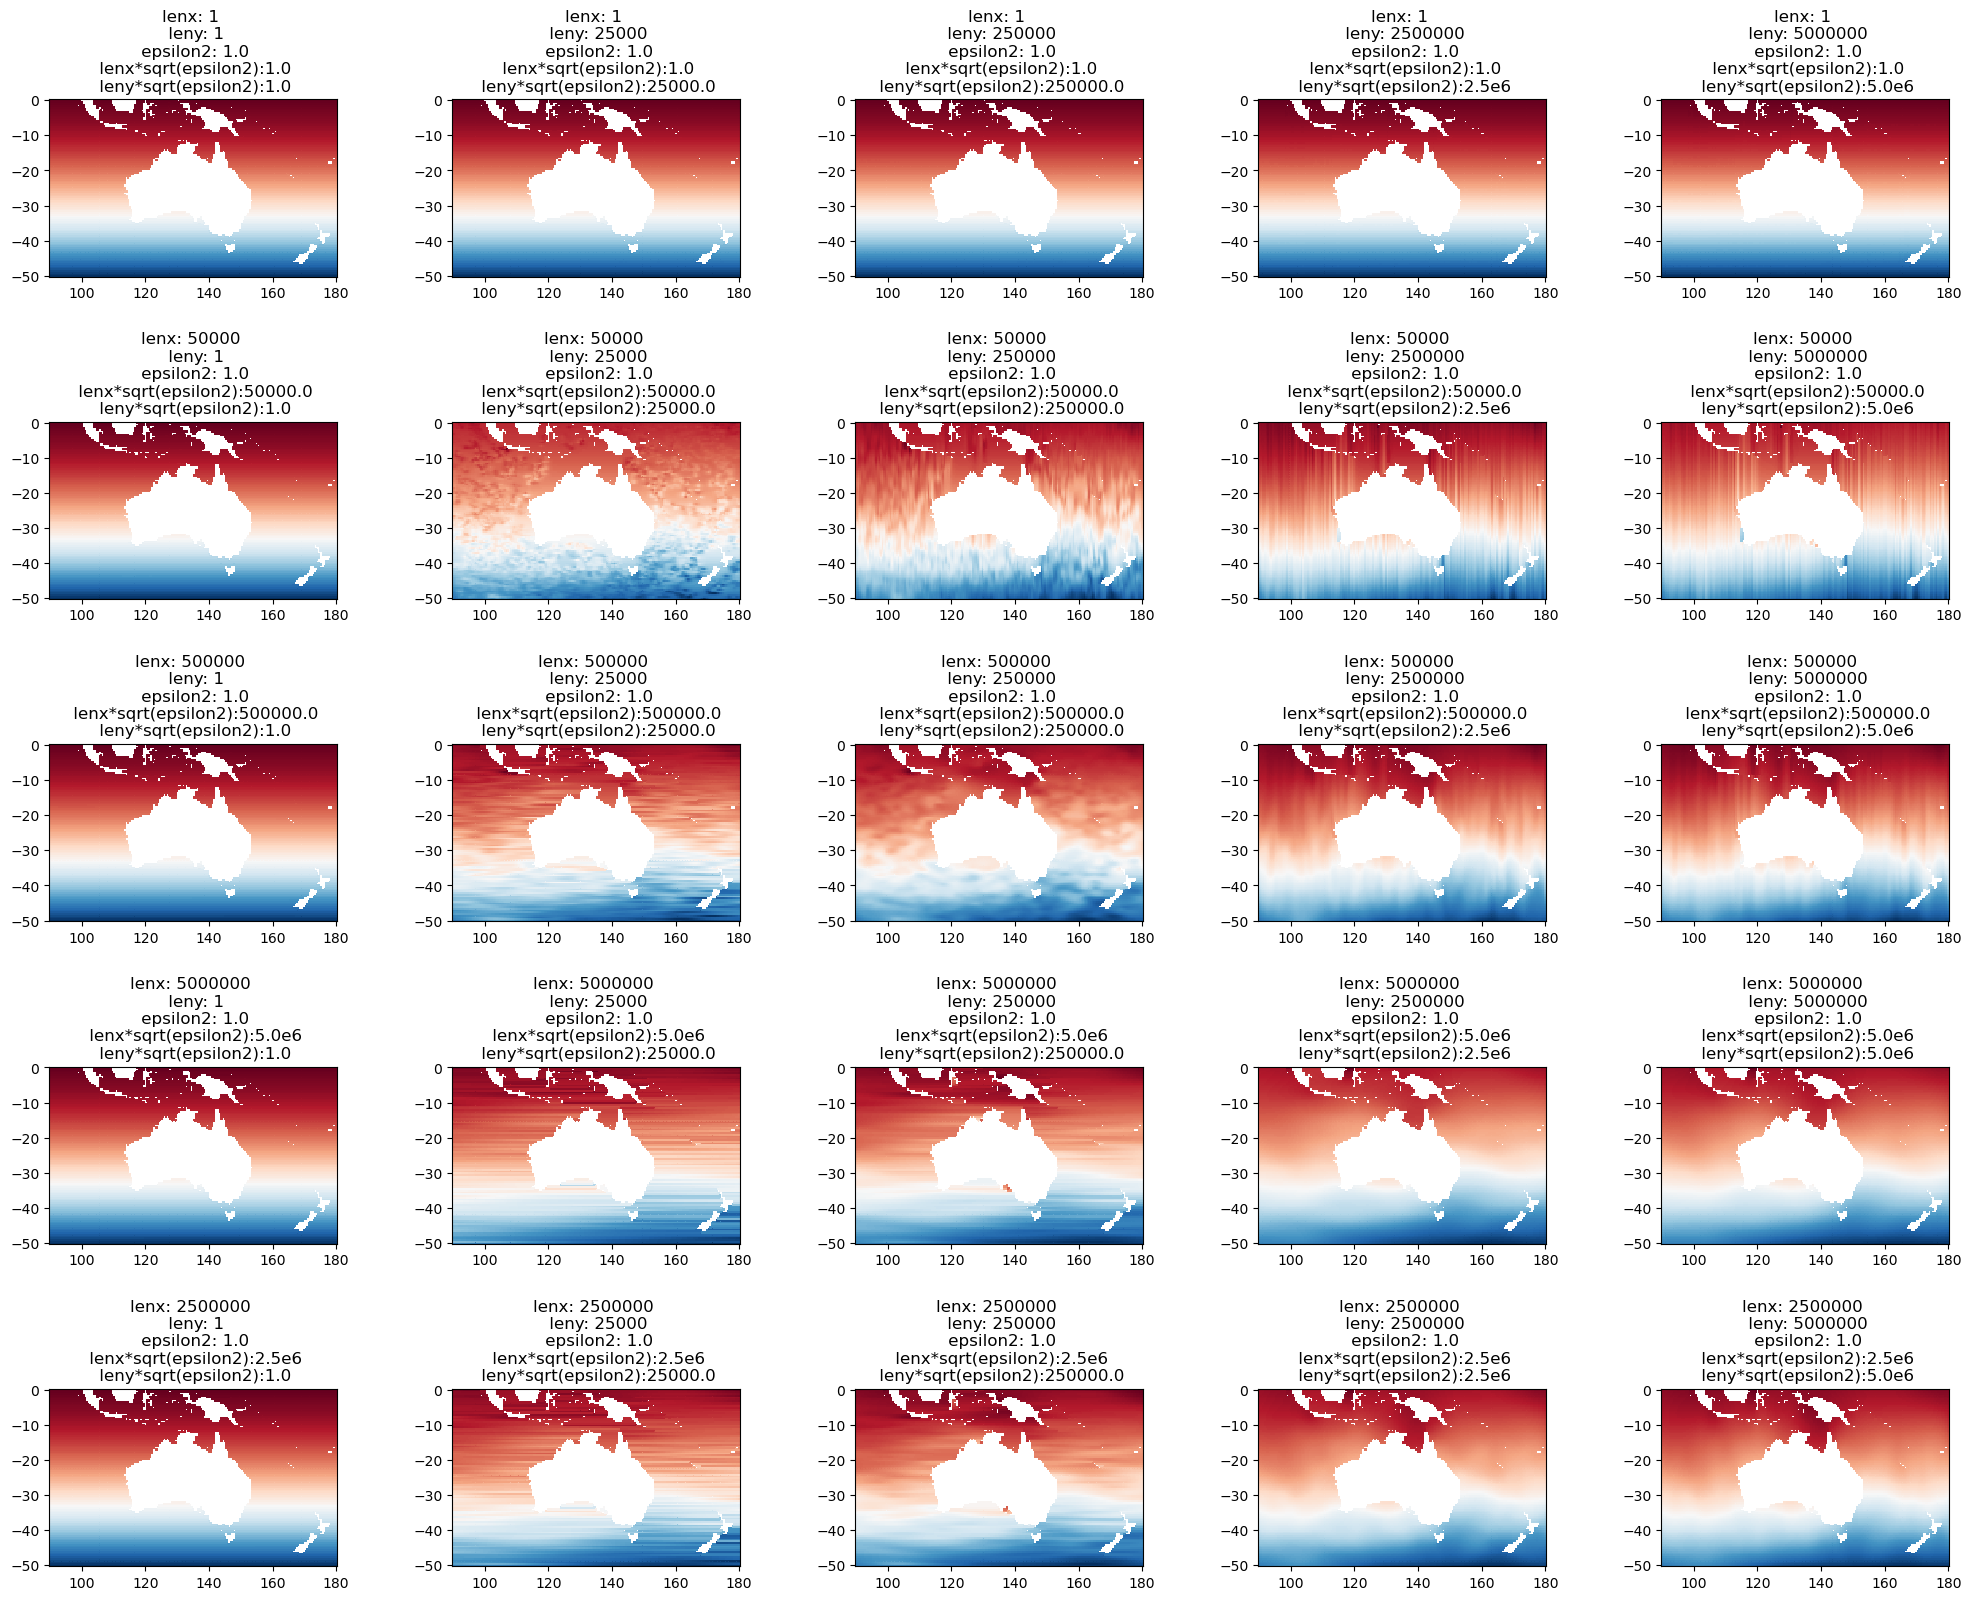

In [35]:
fig = figure(figsize=(10, 8))
subplots_adjust(left = 0.1, bottom = 0.1, right = 2, top = 2, wspace = .4, hspace = .4)
lenxs = [1,50000,500000,5000000,2500000]
lenys = [1,25000,250000,2500000,5000000]
num_cols=length(lenys)
num_rows=length(lenxs)
for i=1:num_cols
    for j=1:num_cols
        lenx=lenxs[i]
        leny=lenys[j]
        epsilon2=1.0
        multix = lenx*sqrt(epsilon2)
        multiy = leny*sqrt(epsilon2)
        #@show i,j,len*sqrt(epsilon2),len,epsilon2
        fi, s = DIVAndrun(mask,(pm,pn),(xi,yi),(longitude.+360,latitude),temperature_residual,(lenx,leny),epsilon2);
        ax = subplot(num_rows,num_cols,(i - 1) * num_cols + j)
        pcolor(xi,yi,fi.+model(yi,fit_temperature_to_latitude.param),cmap="RdBu_r");
        gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))
        title("lenx: $lenx \n leny: $leny\n epsilon2: $epsilon2\n lenx*sqrt(epsilon2):$multix\n leny*sqrt(epsilon2):$multiy") 
    end
end

### write out results from loops using DataFrames

In [36]:
df = DataFrame(Heading1=[1,2,3,4], Heading2=[5,6,7,8])

Row,Heading1,Heading2
,Int64,Int64
1,1,5
2,2,6
3,3,7
4,4,8


# run DIVAnd fit over many combinations of lenx & leny

In [46]:
#lenxs = [1,50000,500000,5000000,2500000]
#lenys = [1,25000,250000,2500000,5000000]
lenxs = exp2.(0:20)
lenys = exp2.(0:20)
arr_error =[]
arr_lenx =[]
arr_leny =[]
arr_epsilon = []
num_cols=length(lenys)
num_rows=length(lenxs)
for i=1:num_cols
    for j=1:num_cols
        lenx=lenxs[i]
        leny=lenys[j]
        epsilon2=1.0
        fi, s = DIVAndrun(mask,(pm,pn),(xi,yi),(longitude.+360,latitude),temperature_residual,(lenx,leny),epsilon2);
        dataresiduals = DIVAnd_residualobs(s,fi)
        mean_error = mean(abs.(dataresiduals))
        push!(arr_error,mean_error)
        push!(arr_lenx,lenx)
        push!(arr_leny,leny)
        push!(arr_epsilon,epsilon2)
    end
end

In [47]:
arr_error

1-element Vector{Any}:
 1.4900247904844421

In [39]:
arr_lenx

441-element Vector{Any}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.048576e6
 1.048576e6
 1.048576e6
 1.048576e6
 1.048576e6
 1.048576e6
 1.048576e6
 1.048576e6
 1.048576e6
 1.048576e6
 1.048576e6
 1.048576e6

In [40]:
arr_leny

441-element Vector{Any}:
      1.0
      2.0
      4.0
      8.0
     16.0
     32.0
     64.0
    128.0
    256.0
    512.0
   1024.0
   2048.0
   4096.0
      ⋮
    512.0
   1024.0
   2048.0
   4096.0
   8192.0
  16384.0
  32768.0
  65536.0
 131072.0
 262144.0
 524288.0
      1.048576e6

In [43]:
X = arr_lenx
Y = arr_leny
Z = arr_error

441-element Vector{Any}:
 1.4900247904844421
 1.4900247747185313
 1.4900247431867124
 1.4900246801230892
 1.4900245539959114
 1.490024301741912
 1.490023797235994
 1.4900227882377333
 1.4900207703375135
 1.4900167352580849
 1.4900086717163759
 1.4899925919207866
 1.4899607709141698
 ⋮
 1.2305032110812066
 1.1959498988856443
 1.1697179965338877
 1.1482971145488017
 1.1293611233040228
 1.1113916826495565
 1.094282844039102
 1.0805121332802703
 1.07620323273333
 1.0850109251194822
 1.1061263002936925
 1.1356506373226194

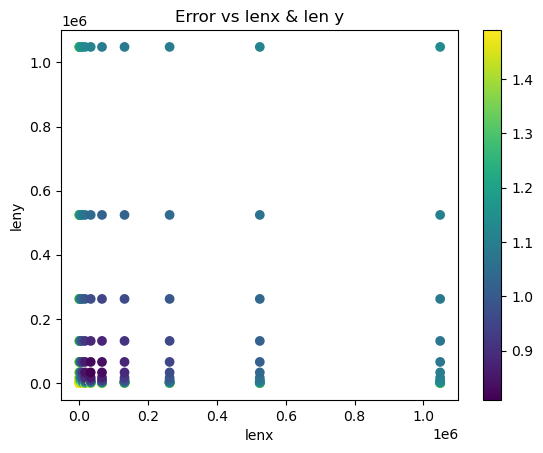

PyObject Text(0.5, 1.0, 'Error vs lenx & len y')

In [45]:
scatter(X, Y, c=Z, cmap="viridis")
colorbar()
xlabel("lenx")
ylabel("leny")
title("Error vs lenx & len y")

## how build structures?

In [ ]:
struct my_data
    epsilon::Float64
    fi::Matrix{Float64}
    s::DIVAnd.DIVAnd_struct
end
    

# --------------------

In [ ]:
size(fi)

In [ ]:
figure("Synth-WOD")
ax = subplot(1,1,1)
scatter(longitude.+360, latitude, c=temperature_residual,cmap="RdBu_r")
aspectratio = 1/cos(mean(latitude) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)
colorbar()

In [ ]:
fit_temperature_to_latitude.param